#Question 1

##Part A

In [ ]:
import torch
from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [ ]:
# MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_data, val_data = train_test_split(train_dataset, test_size=0.2, random_state=42)

##Part B

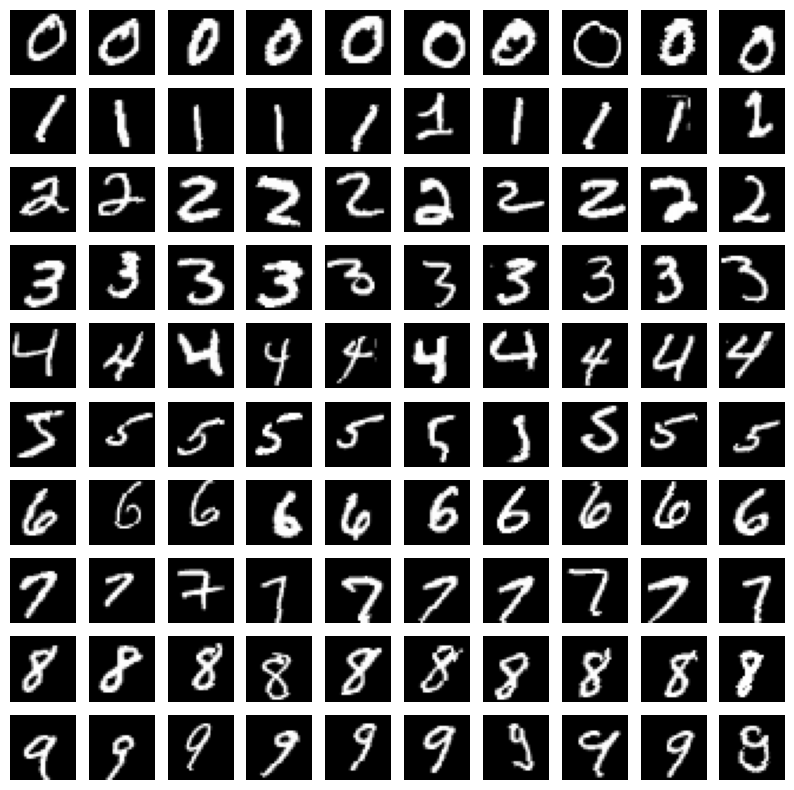

In [ ]:
# Plottin images
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    idxs = np.where(train_dataset.targets == i)[0][:10]
    for j, idx in enumerate(idxs):
        img, label = train_dataset[idx]
        axs[i, j].imshow(img.squeeze(), cmap='gray')
        axs[i, j].axis('off')
plt.show()


In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
# shape of the data
for data, target in train_loader:
    print(data.shape)
    print(target.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [ ]:
input_size=28*28

##Part C

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, self.fc1.in_features)  # Flatten input
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of trainable parameters: 109386


##Part D

In [ ]:
train_loss_arr=[]
train_acc_arr=[]
val_loss_arr=[]
val_acc_arr=[]

def train(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (output.argmax(1) == target).sum().item()
        train_loss /= len(train_loader)
        train_acc /= len(train_dataset)
        val_loss = 0
        val_acc = 0
        model.eval()
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                val_acc += (output.argmax(1) == target).sum().item()
        val_loss /= len(val_loader)
        val_acc /= len(val_data)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pt')
        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3F}, Train Acc: {train_acc:.3F}, Val Loss: {val_loss:.3F}, Val Acc: {val_acc:.3F}')
        train_loss_arr.append(train_loss)
        train_acc_arr.append(train_acc)
        val_loss_arr.append(val_loss)
        val_acc_arr.append(val_acc)
        
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
train(model, train_loader, val_loader, optimizer, criterion,5)

Epoch: 1, Train Loss: 0.018, Train Acc: 0.795, Val Loss: 0.300, Val Acc: 0.959
Epoch: 2, Train Loss: 0.010, Train Acc: 0.798, Val Loss: 0.327, Val Acc: 0.955
Epoch: 3, Train Loss: 0.014, Train Acc: 0.797, Val Loss: 0.336, Val Acc: 0.955
Epoch: 4, Train Loss: 0.014, Train Acc: 0.796, Val Loss: 0.295, Val Acc: 0.962
Epoch: 5, Train Loss: 0.011, Train Acc: 0.797, Val Loss: 0.337, Val Acc: 0.958


##Part E

Correct Predictions


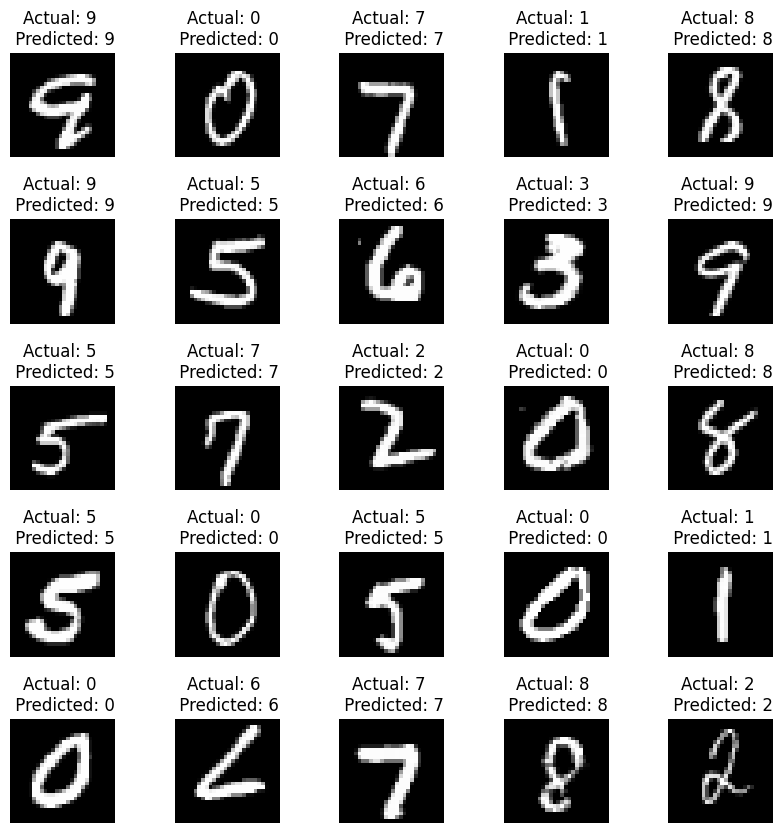

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
correct = []
incorrect = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(1)
        correct.extend([(data[i], target[i], pred[i]) for i in range(len(pred)) if pred[i] == target[i]])
        incorrect.extend([(data[i], target[i], pred[i]) for i in range(len(pred)) if pred[i] != target[i]])
        if len(correct) == 25 and len(incorrect) == 25:
            break

print("Correct Predictions")
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(5):
    for j in range(5):
        img, actual, pred = correct[i*5 + j]
        axs[i, j].imshow(img.squeeze(), cmap='gray')
        axs[i, j].set_title("Actual: {} \n Predicted: {}".format(actual.item(), pred.item()))
        axs[i, j].axis('off')
plt.show()

Incorrect Predictions


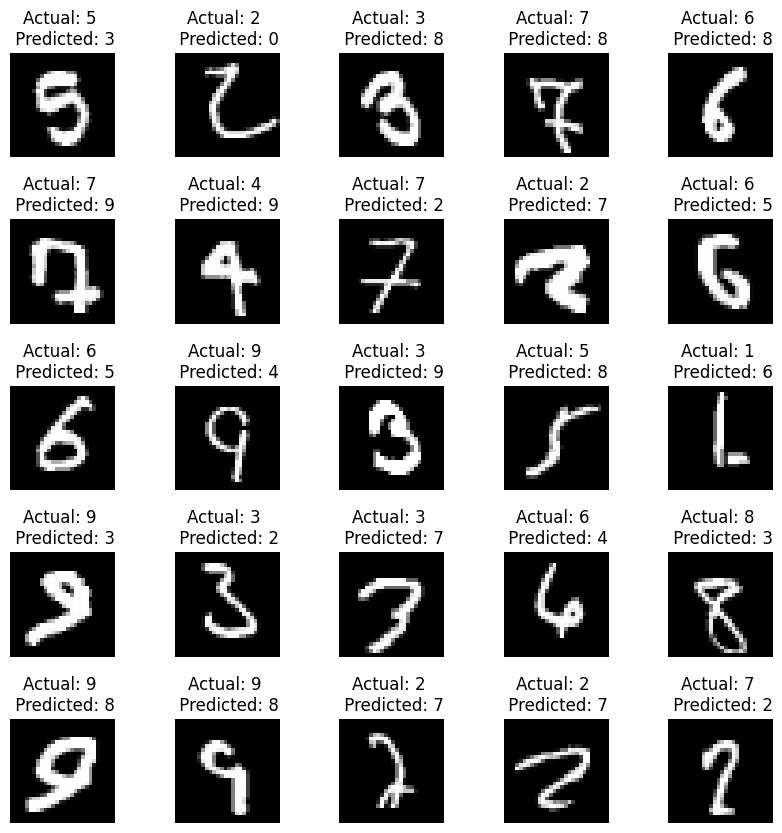

In [ ]:
print("Incorrect Predictions")
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(5):
    for j in range(5):
        img, actual, pred = incorrect[i*5 + j]
        axs[i, j].imshow(img.squeeze(), cmap='gray')
        axs[i, j].set_title("Actual: {} \n Predicted: {}".format(actual.item(), pred.item()))
        axs[i, j].axis('off')
plt.show()

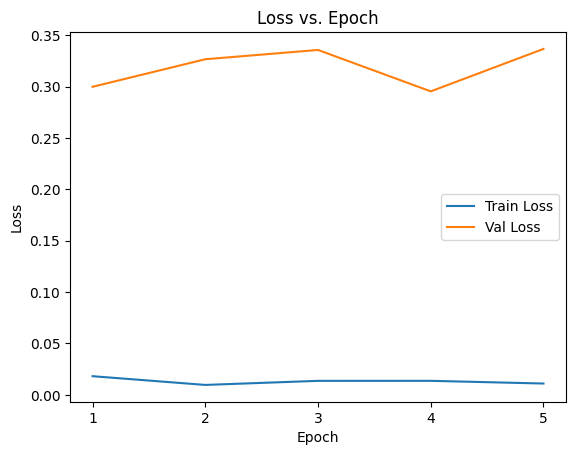

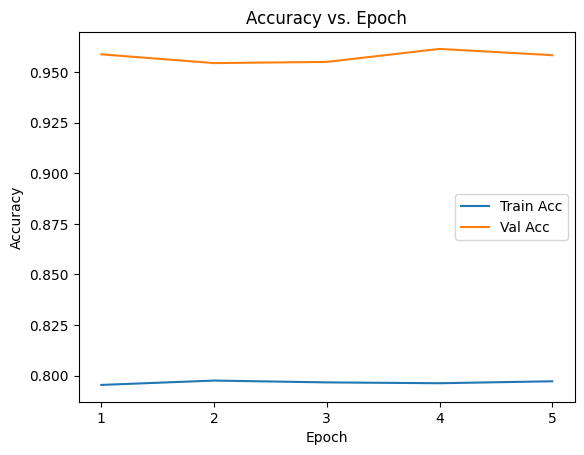

In [ ]:
epochs = range(1, 6)

# Plot Loss vs. Epoch for Training and Validation
plt.plot(epochs, train_loss_arr, label='Train Loss')
plt.plot(epochs, val_loss_arr, label='Val Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()

# Plot Accuracy vs. Epoch for Training and Validation
plt.plot(epochs, train_acc_arr, label='Train Acc')
plt.plot(epochs, val_acc_arr, label='Val Acc')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.show()


#Question 2

##Part A

In [1]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
if os.path.exists('abalone.data'):
    print("Already Present")
else:
    os.system("wget https://www.dropbox.com/s/jfiypwq4vxvfy58/abalone.data")

np.random.seed(2)

In [3]:
column_names = ["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"]
df = pd.read_csv("abalone.data", names=column_names)

In [4]:
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [5]:
df.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [6]:
np.unique(df['Rings'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29])

In [7]:
df.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object

In [8]:
np.unique(df['Sex'])

array(['F', 'I', 'M'], dtype=object)

In [9]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df["Sex"] = encoder.fit_transform(df["Sex"])

# Print the conversion
print("Conversion for Sex column:")
for i, label in enumerate(encoder.classes_):
    print(f"{label} -> {i}")


encoder = LabelEncoder()
df["Rings"] = encoder.fit_transform(df["Rings"])

Conversion for Sex column:
F -> 0
I -> 1
M -> 2


In [10]:
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,14
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,6
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,8
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,9
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,6
...,...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,10
4173,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,9
4174,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,8
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,9


In [11]:
df.describe()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,1.052909,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,8.933445
std,0.822240,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.222790
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,0.000000
25%,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,7.000000
50%,1.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,8.000000
75%,2.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,10.000000
max,2.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,27.000000


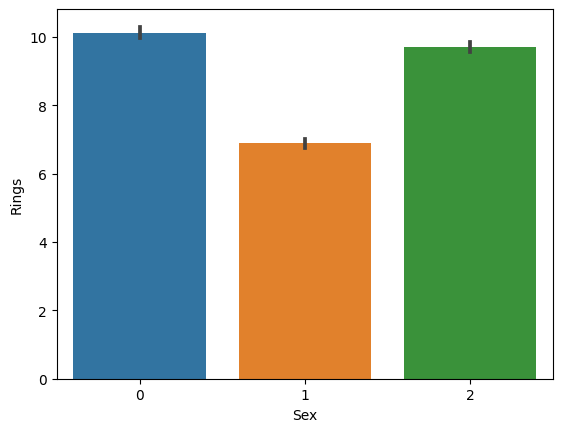

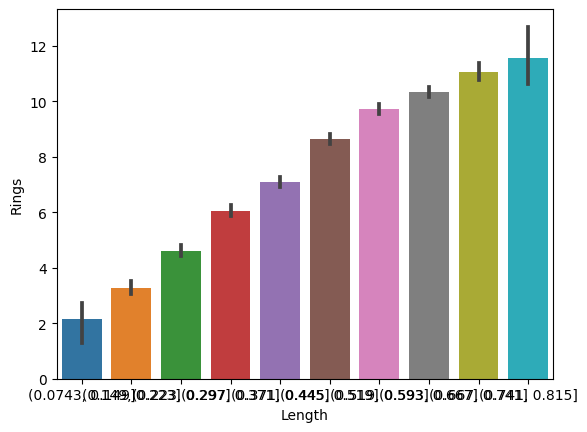

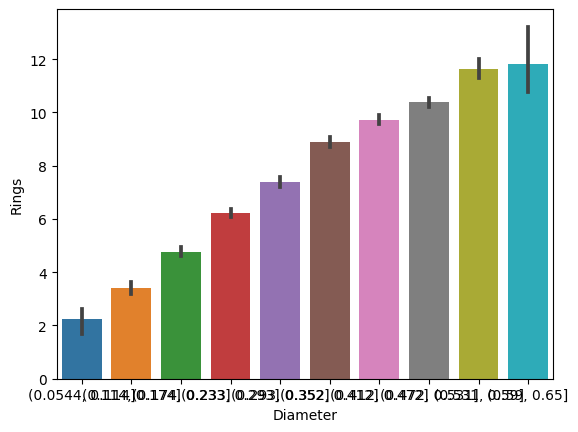

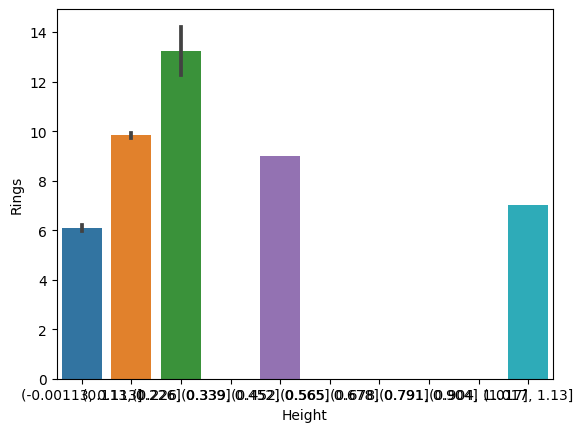

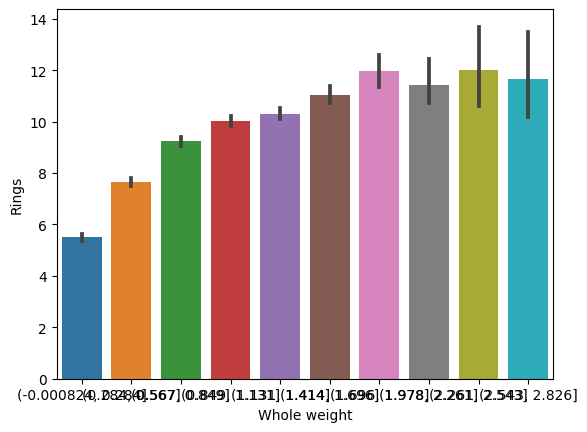

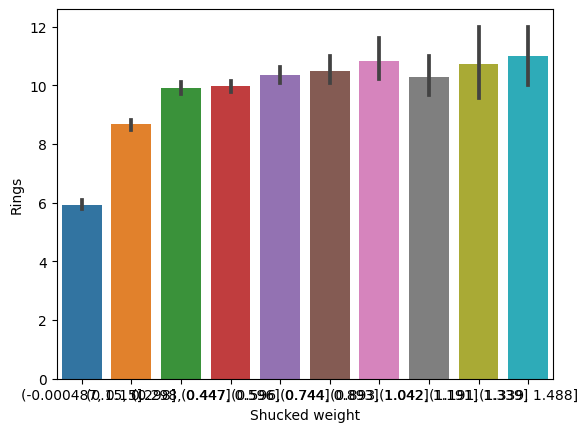

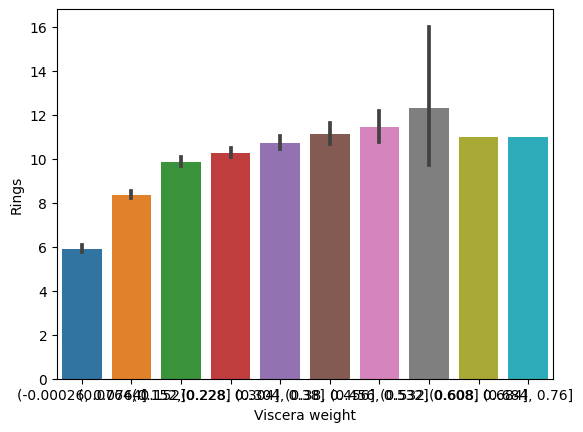

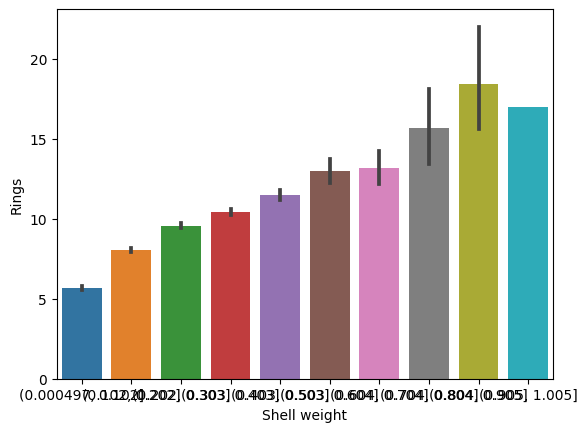

In [12]:
import seaborn as sns
import pandas as pd

# Bar Plots
for column in df.columns[:-1]:  
    plt.figure()
    if column in ["Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight"]:
        sns.barplot(x=pd.cut(df[column], bins=10), y="Rings", data=df)
    else:
        sns.barplot(x=column, y="Rings", data=df)
    plt.xlabel(column)
    plt.ylabel("Rings")
    plt.show()

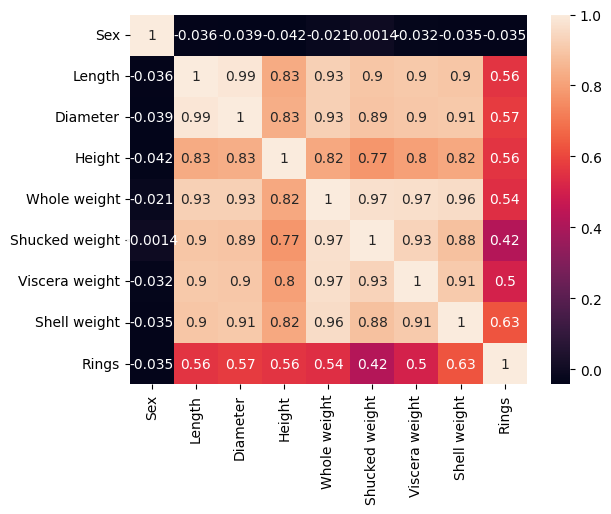

In [13]:
sns.histplot(data=df, x="Rings")

# correlation plot
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# standardization
for col in df.columns[:-1]:
    df[col] = scaler.fit_transform(df[[col]])

In [15]:
unique_values, counts = np.unique(df["Rings"], return_counts=True)
print("Unique_Values:",unique_values)
print("Counts:",counts)

Unique_Values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Counts: [  1   1  15  57 115 259 391 568 689 634 487 267 203 126 103  67  58  42
  32  26  14   6   9   2   1   1   2   1]


In [16]:
df.describe()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4177.000000
mean,-1.275813e-17,-5.834718e-16,-3.027929e-16,3.912493e-16,9.185853e-17,-1.020650e-17,2.704723e-16,2.976897e-16,8.933445
std,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,3.222790
min,-1.280690e+00,-3.739154e+00,-3.556267e+00,-3.335953e+00,-1.686092e+00,-1.614731e+00,-1.643173e+00,-1.705134e+00,0.000000
25%,-1.280690e+00,-6.161975e-01,-5.833158e-01,-5.862075e-01,-7.897577e-01,-7.811585e-01,-7.946415e-01,-7.819095e-01,7.000000
50%,-6.435480e-02,1.749513e-01,1.725193e-01,1.156329e-02,-5.963767e-02,-1.052891e-01,-8.753202e-02,-3.470794e-02,8.000000
75%,1.151980e+00,7.579031e-01,7.267984e-01,6.093341e-01,6.613049e-01,6.426730e-01,6.606355e-01,6.478319e-01,10.000000
max,1.151980e+00,2.423480e+00,2.440025e+00,2.368329e+01,4.072271e+00,5.085388e+00,5.286500e+00,5.504642e+00,27.000000


In [17]:
# threshold for pre-taking class and later adding to train
df_preserved = df.copy(deep=True)
threshold = 3
class_counts = df["Rings"].value_counts()
df_temp = pd.DataFrame()

for cls, count in class_counts.items():
    if count < threshold:
        df_temp = df_temp.append(df[df["Rings"]==cls])

# Drop the rows
df = df.drop(df_temp.index)

# TTS with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df["Rings"], test_size=0.2, stratify=df["Rings"], random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=2)

# Merge df_temp and X_train
X_train = pd.concat([X_train, df_temp.drop(["Rings"], axis=1)])
y_train = pd.concat([y_train, df_temp["Rings"]])

<ipython-input-17-bc10486e4eaf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df[df["Rings"]==cls])
<ipython-input-17-bc10486e4eaf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df[df["Rings"]==cls])
<ipython-input-17-bc10486e4eaf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df[df["Rings"]==cls])
<ipython-input-17-bc10486e4eaf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df[df["Rings"]==cls])
<ipython-input-17-bc10486e4eaf>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

In [18]:
df_temp

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
2108,1.151980,1.174297,1.281078,2.043984,2.762949,1.775881,1.919747,4.642486,26
2209,-1.280690,0.216591,0.575631,0.967997,0.782652,-0.157106,0.222684,2.056019,26
3149,-1.280690,1.465773,1.331467,1.804876,2.343844,1.388382,1.203513,3.385176,23
3280,1.151980,1.382494,1.331467,1.087551,1.612704,0.782353,1.573035,2.271558,23
236,-0.064355,-3.739154,-3.556267,-3.096845,-1.686092,-1.614731,-1.643173,-1.705134,0
294,1.151980,0.632985,0.877965,1.326659,0.466538,0.110989,0.085824,0.978325,25
480,-1.280690,1.465773,1.784968,1.087551,1.996119,1.559602,1.285629,1.696788,27
719,-0.064355,-3.114562,-3.102766,-2.738182,-1.659580,-1.598960,-1.611239,-1.679988,1
2201,-1.280690,1.007740,0.827576,1.804876,1.177284,0.302485,0.437098,1.948250,24


In [19]:
X_train

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
3174,1.151980,-0.616198,-0.532927,-0.466653,-0.883572,-0.956885,-0.949749,-0.674140
2661,1.151980,0.341509,0.222908,-0.227545,-0.091249,-0.044461,0.072138,-0.185585
231,1.151980,0.341509,0.323686,0.848442,0.150425,-0.222440,0.113196,0.619093
247,-0.064355,-1.365707,-1.339151,-1.303532,-1.287381,-1.283555,-1.269089,-1.212987
4154,-0.064355,-0.741116,-0.784872,-1.064424,-0.888671,-0.632467,-0.963435,-1.080072
...,...,...,...,...,...,...,...,...
236,-0.064355,-3.739154,-3.556267,-3.096845,-1.686092,-1.614731,-1.643173,-1.705134
294,1.151980,0.632985,0.877965,1.326659,0.466538,0.110989,0.085824,0.978325
480,-1.280690,1.465773,1.784968,1.087551,1.996119,1.559602,1.285629,1.696788
719,-0.064355,-3.114562,-3.102766,-2.738182,-1.659580,-1.598960,-1.611239,-1.679988


In [20]:
y_train

3174     8
2661     8
231     13
247      8
4154     5
        ..
236      0
294     25
480     27
719      1
2201    24
Name: Rings, Length: 2676, dtype: int64

In [21]:
unique_values, counts = np.unique(y_train, return_counts=True)
print("Class distribution in train set:")
for val, count in zip(unique_values, counts):
    print(f"{val}: {count/len(y_train):.2%}")
    
print()

unique_values, counts = np.unique(y_test, return_counts=True)
print("Class distribution in test set:")
for val, count in zip(unique_values, counts):
    print(f"{val}: {count/len(y_test):.2%}")

Class distribution in train set:
0: 0.04%
1: 0.04%
2: 0.37%
3: 1.38%
4: 2.77%
5: 6.17%
6: 9.34%
7: 13.57%
8: 16.48%
9: 15.13%
10: 11.62%
11: 6.39%
12: 4.82%
13: 3.03%
14: 2.47%
15: 1.61%
16: 1.38%
17: 1.01%
18: 0.78%
19: 0.64%
20: 0.34%
21: 0.15%
22: 0.22%
23: 0.07%
24: 0.04%
25: 0.04%
26: 0.07%
27: 0.04%

Class distribution in test set:
2: 0.36%
3: 1.32%
4: 2.76%
5: 6.24%
6: 9.35%
7: 13.67%
8: 16.55%
9: 15.23%
10: 11.75%
11: 6.35%
12: 4.92%
13: 3.00%
14: 2.52%
15: 1.56%
16: 1.44%
17: 0.96%
18: 0.72%
19: 0.60%
20: 0.36%
21: 0.12%
22: 0.24%


In [22]:
num_labels = len(np.unique(df_preserved["Rings"]))
print(num_labels)

28


In [23]:
# Apply one-hot encoding
y_one_hot_train = np.eye(num_labels)[np.array(y_train).astype(int).reshape(1,-1)]
y_reshaped_train = y_one_hot_train.reshape(-1, num_labels)

y_one_hot_test = np.eye(num_labels)[np.array(y_test).astype(int).reshape(1,-1)]
y_reshaped_test = y_one_hot_test.reshape(-1, num_labels)

y_one_hot_val = np.eye(num_labels)[np.array(y_val).astype(int).reshape(1,-1)]
y_reshaped_val = y_one_hot_val.reshape(-1, num_labels)

##Part B


In [24]:
import pickle
class ANN_scratch:
    def __init__(self, input_dim, hidden_layers,output_dim,layer_dim,activation,batch_size=100,learning_rate=0.01,weight_init='random',onebynthweight_value=8,gradient_clip=0.5):
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.preserved_learning_rate = learning_rate
        self.activations=activation
        self.batch_size=batch_size
        self.weight_init=weight_init
        self.gradien_clip=gradient_clip
        self.onebynthweight_value=onebynthweight_value
        self.layer_dim=[]
        self.layer_dim.append(input_dim)
        for i in range(self.hidden_layers):
            self.layer_dim.append(layer_dim[i])
        self.layer_dim.append(output_dim)
        
        self.layers={}
        self.layers_init()
    def layers_init(self):
        for i in range(1,self.hidden_layers+1):
            parametrs={}
            if self.weight_init=='random':
                weights=np.random.randn(self.layer_dim[i],self.layer_dim[i-1])
            elif self.weight_init=='zero':
                weights=np.zeros((self.layer_dim[i],self.layer_dim[i-1]))
            elif self.weight_init=='constant':
                weights=np.ones((self.layer_dim[i],self.layer_dim[i-1]))/self.onebynthweight_value
            bias=np.random.randn(self.layer_dim[i],1)
            activation=self.activations[i-1]
            parametrs['weights']=weights
            parametrs['bias']=bias
            parametrs['activation']=activation
            self.layers[i-1]=parametrs
            # print("Parametrs of layer ",i-1,": ",parametrs)

    def activation(self, activation_type, x):
        if (activation_type == 'sigmoid'):
            return 1 / (1 + np.exp(-x))
        elif (activation_type == 'tanh'):
            return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        elif (activation_type == 'relu'):
            return np.maximum(0, x)
        elif (activation_type == 'leaky_relu'):
            return np.where(x > 0, x, x * 0.01)
        elif (activation_type == 'softmax'):
            e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
            return e_x / np.sum(e_x, axis=1, keepdims=True)
        elif (activation_type == 'linear'):
            return x
        
    def loss(self, loss_fxn, y, y_hat):
        if (loss_fxn == 'mse'):
            return np.mean(np.square(y - y_hat)), y_hat
        elif (loss_fxn == 'cross_entropy'):
            # add 1e-8 to avoid log(0)
            y_hat = np.clip(y_hat, 1e-8, 1 - 1e-8)
            loss = -np.mean(y * np.log(y_hat), axis=1)
            return loss, y_hat


    def loss_fxn_da(self, loss_fxn, y, y_hat):
        if loss_fxn == 'mse':
            return -2 * (y - y_hat)
        elif loss_fxn == 'cross_entropy':
            return (y_hat - y) / (y_hat * (1 - y_hat))

        
    def activation_derivative(self, activation_type, z):
        if activation_type == 'sigmoid':
            return self.activation('sigmoid', z) * (1 - self.activation('sigmoid', z))
        elif activation_type == 'tanh':
            return 1 - self.activation('tanh', z)**2
        elif activation_type == 'relu':
            return np.where(z > 0, 1, 0)
        elif activation_type == 'leaky_relu':
            return np.where(z > 0, 1, 0.01)
        elif activation_type == 'linear':
            return 1
        elif activation_type == 'softmax':
            s = self.activation('softmax', z)
            return s * (1 - s)

    def forward_propagate(self, a_prev, layer_number):
        layer = self.layers[layer_number]
        weights = layer['weights']
        bias = layer['bias']
        activation_type = layer['activation']
        z = np.dot(weights, a_prev) + bias
        a = self.activation(activation_type, z)
        return a, z
    
    def backward_propagate(self, za, zs, y, y_hat,X,loss_fxn):
        da = self.loss_fxn_da(loss_fxn, y, y_hat)
        m=X.shape[1]
        for i in range(len(self.layers) - 1, -1, -1):
            layer = self.layers[i]
            weights = layer['weights']
            activation_type = layer['activation']
            z = zs[i]
            a = za[i]
            # if activation_type == 'softmax' and i==len(self.layers) - 1:
            #     dz =  self.activation_derivative(activation_type, z) * da
            # else:
            # print("weights:",weights.shape)
            # print("da:",da.shape)
            if i != len(self.layers) - 1:
                # print("self.layers[i+1]['weights']:",self.layers[i+1]['weights'].shape)
                # print("da:",da.shape)
                da= np.dot(self.layers[i+1]['weights'].T, dz)
            dz = self.activation_derivative(activation_type, z) * da
            # print("dz:",dz.shape)
            # print("a:",a.shape)
            if(i==0):
                a_prev=X
            else:
                a_prev=za[i-1]
            self.update_parameters(i, dz, a_prev,self.learning_rate,m, clip_value=self.gradien_clip)
        
    def update_parameters(self, layer_number, dz, a_prev, learning_rate, m, clip_value):
        weights = self.layers[layer_number]['weights']
        bias = self.layers[layer_number]['bias']
        
        # Calculate the gradients with respect to the weights and bias
        dW = np.dot(dz, a_prev.T) / m
        db = np.sum(dz, axis=1, keepdims=True) / m
        
        # Clip the gradients to the given value
        dW = np.clip(dW, -clip_value, clip_value)
        db = np.clip(db, -clip_value, clip_value)
        
        # Update the weights and bias using the clipped gradients
        weights -= learning_rate * dW
        bias -= learning_rate * db
        
        self.layers[layer_number]['weights'] = weights
        self.layers[layer_number]['bias'] = bias


    def single_pass_loss(self,x_train, y_train,m,loss_fxn):
        cnt = 0
        train_loss = []
        while cnt * self.batch_size < m:
            x_batch = x_train[:, cnt * self.batch_size : (cnt + 1) * self.batch_size]
            y_batch = y_train[:, cnt * self.batch_size : (cnt + 1) * self.batch_size]

            a = x_batch
            zs = []
            za = []
            for j in range(self.hidden_layers):
                a, z = self.forward_propagate(a, j)
                zs.append(z)
                za.append(a)
            y_hat = a
            # add 1e-8 to avoid log(0)
            y_hat = np.clip(y_hat, 1e-8, 1 - 1e-8)
            loss, _ = self.loss(loss_fxn, y_batch, y_hat)
            train_loss.append(loss)
            self.backward_propagate(za, zs, y_batch, y_hat, x_batch, loss_fxn)
            cnt += 1
        
        return np.mean(train_loss)

    def train(self, x_train, y_train, x_val,y_val, epochs, loss_fxn,decay_rate=0.01, validation_split=0.2,rst=0.1,decay_loop=25):
        m = y_train.shape[1]
        history = {}
        train_loss_hist=[]
        val_loss_hist=[]
        train_acc_hist=[]
        val_acc_hist=[]

        for epoch in range(epochs):
            cnt = 0
            train_loss = []
            while cnt * self.batch_size < m:
                x_batch = x_train[:, cnt * self.batch_size : (cnt + 1) * self.batch_size]
                y_batch = y_train[:, cnt * self.batch_size : (cnt + 1) * self.batch_size]

                a = x_batch
                zs = []
                za = []
                for j in range(self.hidden_layers):
                    a, z = self.forward_propagate(a, j)
                    zs.append(z)
                    za.append(a)
                y_hat = a
                # add 1e-8 to avoid log(0)
                y_hat = np.clip(y_hat, 1e-8, 1 - 1e-8)
                loss, _ = self.loss(loss_fxn, y_batch, y_hat)
                train_loss.append(loss)
                self.backward_propagate(za, zs, y_batch, y_hat, x_batch, loss_fxn)
                cnt += 1

            train_loss = np.mean(train_loss)


            if epoch % decay_loop == 0:
                self.learning_rate = self.preserved_learning_rate* np.exp(-decay_rate * epoch)

            #store train_loss and train_acc
            if loss_fxn =='cross_entropy':
                if np.isnan(np.mean(loss)) and epoch %15==0 and epoch > 0:
                  for i in range(5):
                    if (not(np.isnan(train_loss))):
                      break
                    self.layers_init()
                    for i in range(epoch):
                      train_loss=self.single_pass_loss(x_train, y_train,m,loss_fxn)
                train_loss_hist.append(train_loss)
                train_acc_hist.append(self.accuracy(x_train,y_train,loss_fxn))
            elif loss_fxn=='mse':
                train_loss_hist.append(train_loss)
                val_acc_hist.append(self.accuracy(x_val,y_val,loss_fxn))  

            #store val_loss and val_acc
            if loss_fxn =='cross_entropy':
                loss, _ =self.loss(loss_fxn, y_val,self.predict(x_val))
                if np.isnan(np.mean(loss)):
                  for i in range(5):
                    if(not(np.isnan(train_loss))) and epoch %15==0 and epoch > 0:
                      break
                    self.layers_init()
                    for i in range(epoch):
                      train_loss=self.single_pass_loss(x_train, y_train,m,loss_fxn)
                val_acc_hist.append(self.accuracy(x_val,y_val,loss_fxn))
                val_loss_hist.append(np.mean(loss))
            elif loss_fxn=='mse':
                val_loss_hist.append(np.mean(loss))
                val_acc_hist.append(self.accuracy(x_val,y_val,loss_fxn))
            
            if epoch % 10 == 0:
                if np.isnan(train_loss):
                    print("Epoch: ", (epoch+1), " Train Loss: ")
                else:
                    if loss_fxn =='cross_entropy':
                        loss, _ =self.loss(loss_fxn, y_val,self.predict(x_val))
                        print("Epoch: ", (epoch+1), " Train Loss: ", train_loss, " Val loss: ", np.mean(loss))
                        print("Epoch: ", (epoch+1), " Train acc: ", train_acc_hist[-1], " Val acc: ", val_acc_hist[-1])

                    elif loss_fxn=='mse':
                        print("Epoch: ", (epoch+1), " Train Loss: ", train_loss, " Val loss: ", self.accuracy(x_val,y_val,'mse'))
            

            #Weight reset
            wei_rst=0
            if epoch % 25==0 and epoch>0:
                if(train_loss>rst):
                    wei_rst=1
                    self.preserved_learning_rate /= 2
                    self.learning_rate =self.preserved_learning_rate 
                    print("Weights reset",end=" ")
                    for i in range(5):
                      if (train_loss < rst):
                        break
                      print(i+1,end=" ")
                      self.layers_init()
                      for i in range (epoch):
                          train_loss=self.single_pass_loss(x_train, y_train,m,loss_fxn)
                      print("Debug train_acc: ",self.accuracy(x_train,y_train,loss_fxn),end=" ")
            if wei_rst:
              print()
            # Check convergence
            if epoch > 0 and epoch % 25 == 0 and wei_rst==0:
                if abs(train_loss_hist[-1] - train_loss_hist[-2]) < train_loss_hist[-2]*1e-6 and epoch > 10:
                    print(f"Converged after {epoch} epochs.")
                    # print(f"Accuracy at {epoch} epochs is {np.mean(batch_loss)}")
                    break
        history={'train_loss':train_loss_hist,'val_loss':val_loss_hist,'train_acc':train_acc_hist,'val_acc':val_acc_hist}
        return history


    def predict(self,x):
        a=x
        for j in range(self.hidden_layers):
            a, z = self.forward_propagate(a, j)
        return a
    
    def accuracy(self,x,y,loss_fxn):
        if loss_fxn=='mse':
            y_hat=self.predict(x)
            loss, _ = self.loss(loss_fxn, y, y_hat)
            return np.mean(loss)
        elif loss_fxn=='cross_entropy':
            y_hat=self.predict(x)
            y_hat=np.argmax(y_hat,axis=0)
            y=np.argmax(y,axis=0)
            return np.sum(y_hat==y)/y.shape[0]
    def save_weights(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.layers, f)
    
    def load_weights(self, filename):
        with open(filename, 'rb') as f:
            self.layers = pickle.load(f)
            self.layers['activation']=self.activations
        

##Part C

Epoch:  1  Train Loss:  0.06831082197779836  Val loss:  0.07169867776384775
Epoch:  1  Train acc:  0.01195814648729447  Val acc:  0.013493253373313344
Epoch:  11  Train Loss:  0.08977991682207737  Val loss:  0.08875798922451605
Epoch:  11  Train acc:  0.21113602391629296  Val acc:  0.22788605697151423
Epoch:  21  Train Loss:  0.08708598762960303  Val loss:  0.08679083496063403
Epoch:  21  Train acc:  0.22683109118086697  Val acc:  0.22188905547226387
Epoch:  31  Train Loss:  0.08524868507573406  Val loss:  0.08533247055587981
Epoch:  31  Train acc:  0.23430493273542602  Val acc:  0.23388305847076463
Epoch:  41  Train Loss:  0.08366396736362451  Val loss:  0.08392401029215012
Epoch:  41  Train acc:  0.24439461883408073  Val acc:  0.2353823088455772
Epoch:  51  Train Loss:  0.082363570365645  Val loss:  0.08268949825194123
Epoch:  51  Train acc:  0.2552316890881913  Val acc:  0.2368815592203898
Epoch:  61  Train Loss:  0.08135879478511972  Val loss:  0.08175309312626478
Epoch:  61  Train

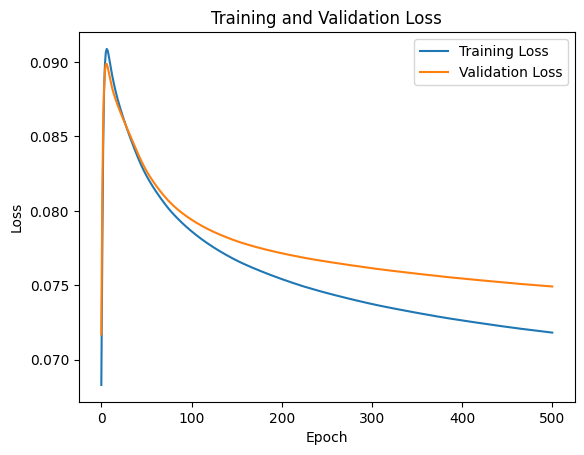

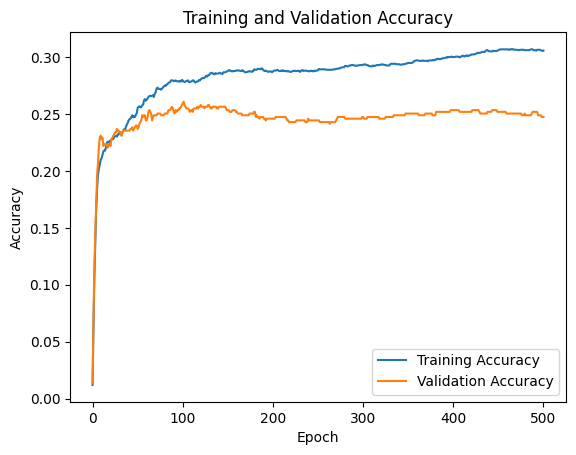

In [ ]:
#Sigmoid
layer_dim=[512,128,64,num_labels]
activation=['sigmoid','sigmoid','sigmoid','sigmoid']
model=ANN_scratch(8,4,num_labels,layer_dim,activation,batch_size=16,learning_rate=0.001)
history=model.train(X_train.values.T,y_reshaped_train.T,X_val.values.T,y_reshaped_val.T,501,'cross_entropy',decay_rate=0.001,rst=0.1,decay_loop=75)
print(f"Accuracy on test data: {model.accuracy(X_test.values.T,y_reshaped_test.T,'cross_entropy')}")

#train and validation loss over epoch
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and alidation accuracy over epoch
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch:  1  Train Loss:  0.30262559825149377  Val loss:  0.46346910325589724
Epoch:  1  Train acc:  0.12369207772795217  Val acc:  0.08995502248875563
Epoch:  11  Train Loss:  0.13534502531464004  Val loss:  0.3508731525055853
Epoch:  11  Train acc:  0.1804932735426009  Val acc:  0.1934032983508246
Epoch:  21  Train Loss:  0.12772504199061463  Val loss:  0.3542899597617461
Epoch:  21  Train acc:  0.18348281016442453  Val acc:  0.19490254872563717
Epoch:  31  Train Loss:  0.13012106428063933  Val loss:  0.38051125223349364
Epoch:  31  Train acc:  0.21076233183856502  Val acc:  0.19940029985007496
Epoch:  41  Train Loss:  0.13505177911060506  Val loss:  0.38422427593786485
Epoch:  41  Train acc:  0.20590433482810164  Val acc:  0.1934032983508246
Epoch:  51  Train Loss:  0.13382423593814374  Val loss:  0.38559803032429946
Epoch:  51  Train acc:  0.20964125560538116  Val acc:  0.18140929535232383
Epoch:  61  Train Loss:  0.12868317103377497  Val loss:  0.3830394437618901
Epoch:  61  Train a

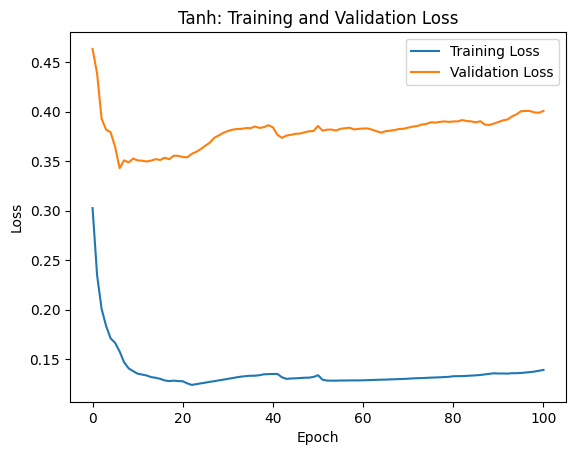

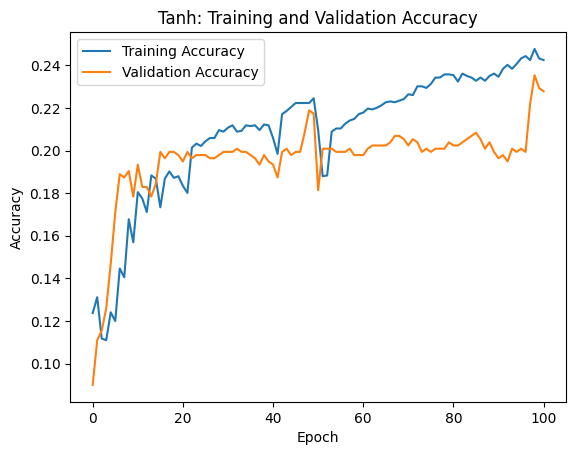

In [ ]:
# Tanh activation function
layer_dim=[512,128,64,num_labels]
activation=['tanh','tanh','tanh','softmax']
model=ANN_scratch(8,4,num_labels,layer_dim,activation,batch_size=16,learning_rate=0.01)
history=model.train(X_train.values.T,y_reshaped_train.T,X_val.values.T,y_reshaped_val.T,101,'cross_entropy',decay_rate=0.001,rst=0.15,decay_loop=25)
print(f"Accuracy on test data with Tanh activation function: {model.accuracy(X_test.values.T, y_reshaped_test.T, 'cross_entropy')}")

#train and validation loss over epoch
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Tanh: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and alidation accuracy over epoch
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Tanh: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<ipython-input-196-05b774e1e933>:39: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch:  1  Train Loss:  0.3296669818881561  Val loss:  0.3857380696226919
Epoch:  1  Train acc:  0.06203288490284006  Val acc:  0.05247376311844078
Epoch:  11  Train Loss:  0.5375450159547575  Val loss:  0.5511471046983485
Epoch:  11  Train acc:  0.1446188340807175  Val acc:  0.14992503748125938
Epoch:  21  Train Loss:  0.5577817576418869  Val loss:  0.5564980397444582
Epoch:  21  Train acc:  0.15059790732436473  Val acc:  0.15292353823088456
Epoch:  31  Train Loss:  0.5576710797435553  Val loss:  0.556634094025027
Epoch:  31  Train acc:  0.15059790732436473  Val acc:  0.15292353823088456
Epoch:  41  Train Loss:  0.5576706633218933  Val loss:  0.5566524902941051
Epoch:  41  Train acc:  0.15059790732436473  Val acc:  0.15292353823088456
Epoch:  51  Train Loss:  0.55767052193083  Val loss:  0.5566559447793139
Epoch:  51  Train acc:  0.15059790732436473  Val acc:  0.15292353823088456
Converged after 50 epochs.
Accuracy on test data with ReLU activation function: 0.15227817745803357


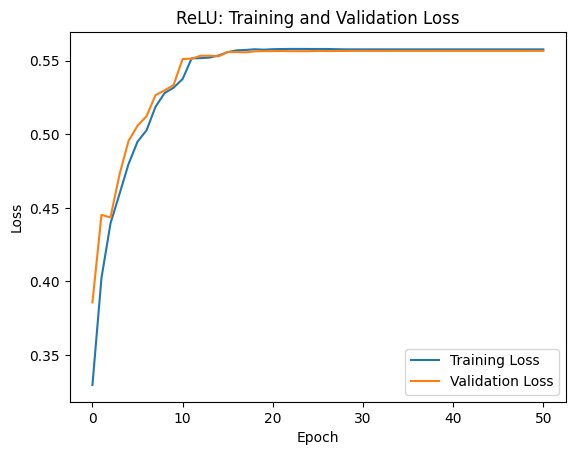

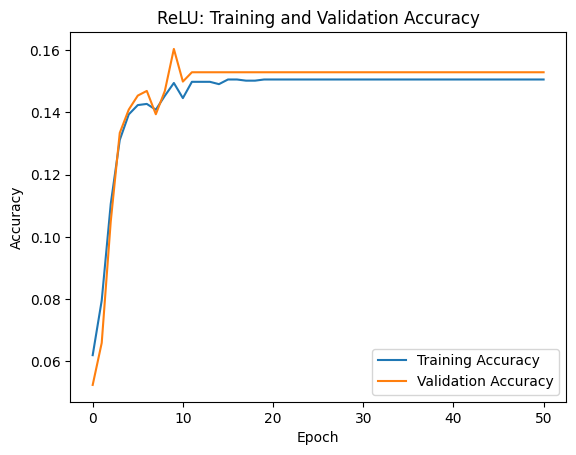

In [ ]:
# ReLU 
layer_dim=[512,64,32,num_labels]
activation=['leaky_relu','leaky_relu','leaky_relu','sigmoid']
model=ANN_scratch(8,4,num_labels,layer_dim,activation,batch_size=128,learning_rate=0.005,gradient_clip=0.3)
history=model.train(X_train.values.T,y_reshaped_train.T,X_val.values.T,y_reshaped_val.T,151,'cross_entropy',decay_rate=0.05,rst=0.7,decay_loop=15)
print(f"Accuracy on test data with ReLU activation function: {model.accuracy(X_test.values.T, y_reshaped_test.T, 'cross_entropy')}")

#train and validation loss over epoch
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('ReLU: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and alidation accuracy over epoch
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('ReLU: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##Part D

Epoch:  1  Train Loss:  0.052982306801667996  Val loss:  0.06886684873758962
Epoch:  1  Train acc:  0.04708520179372197  Val acc:  0.043478260869565216
Epoch:  11  Train Loss:  0.09215036654852649  Val loss:  0.0926074870767053
Epoch:  11  Train acc:  0.19133034379671152  Val acc:  0.17391304347826086
Epoch:  21  Train Loss:  0.0875431423760362  Val loss:  0.08739188821068908
Epoch:  21  Train acc:  0.1984304932735426  Val acc:  0.191904047976012
Epoch:  31  Train Loss:  0.08512230364754506  Val loss:  0.08457211267910736
Epoch:  31  Train acc:  0.2062780269058296  Val acc:  0.2098950524737631
Epoch:  41  Train Loss:  0.08348271852659964  Val loss:  0.08274573446502072
Epoch:  41  Train acc:  0.2290732436472347  Val acc:  0.21889055472263869
Epoch:  51  Train Loss:  0.08235943354243387  Val loss:  0.08158684858190626
Epoch:  51  Train acc:  0.23804185351270554  Val acc:  0.22038980509745126
Epoch:  61  Train Loss:  0.08153484857513915  Val loss:  0.08080484010872835
Epoch:  61  Train a

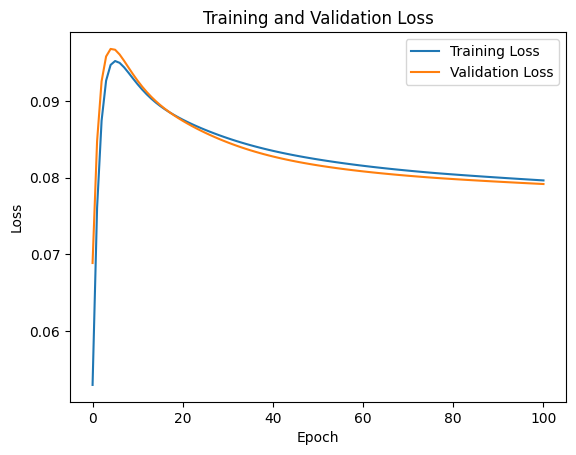

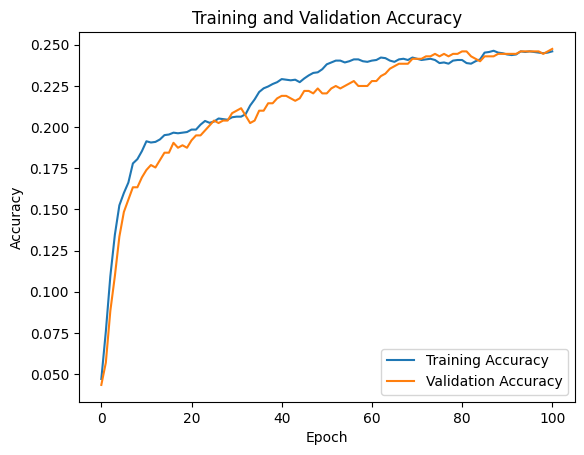

In [ ]:
#Random
layer_dim=[512,128,64,num_labels]
activation=['sigmoid','sigmoid','sigmoid','sigmoid']
model=ANN_scratch(8,4,num_labels,layer_dim,activation,batch_size=16,learning_rate=0.001,weight_init='random')
history=model.train(X_train.values.T,y_reshaped_train.T,X_val.values.T,y_reshaped_val.T,101,'cross_entropy',decay_rate=0.001,rst=0.1,decay_loop=75)
print(f"Accuracy on test data: {model.accuracy(X_test.values.T,y_reshaped_test.T,'cross_entropy')}")

#train and validation loss over epoch
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and alidation accuracy over epoch
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch:  1  Train Loss:  0.03471811675559501  Val loss:  0.04408944146375872
Epoch:  1  Train acc:  0.02765321375186846  Val acc:  0.026986506746626688
Epoch:  11  Train Loss:  0.08721883798484098  Val loss:  0.08678721220251052
Epoch:  11  Train acc:  0.1647982062780269  Val acc:  0.16491754122938532
Epoch:  21  Train Loss:  0.08905738153068905  Val loss:  0.08821865845150338
Epoch:  21  Train acc:  0.1647982062780269  Val acc:  0.16491754122938532
Epoch:  31  Train Loss:  0.0895476770970546  Val loss:  0.08855489732266156
Epoch:  31  Train acc:  0.1647982062780269  Val acc:  0.16491754122938532
Epoch:  41  Train Loss:  0.08976452854862407  Val loss:  0.08867898249745142
Epoch:  41  Train acc:  0.1647982062780269  Val acc:  0.16491754122938532
Epoch:  51  Train Loss:  0.08988472160477864  Val loss:  0.08873442107397911
Epoch:  51  Train acc:  0.1647982062780269  Val acc:  0.16491754122938532
Epoch:  61  Train Loss:  0.0899611444941158  Val loss:  0.08876225794542066
Epoch:  61  Train a

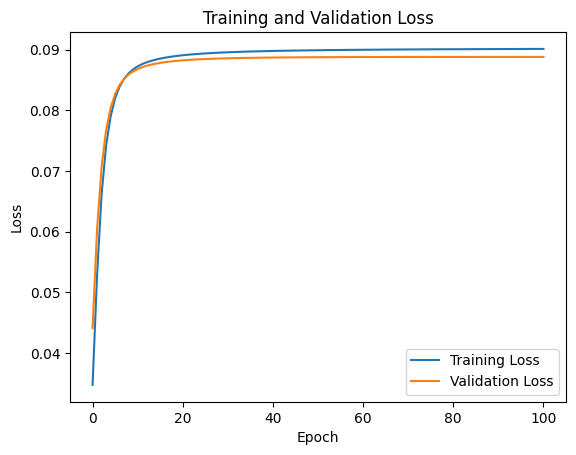

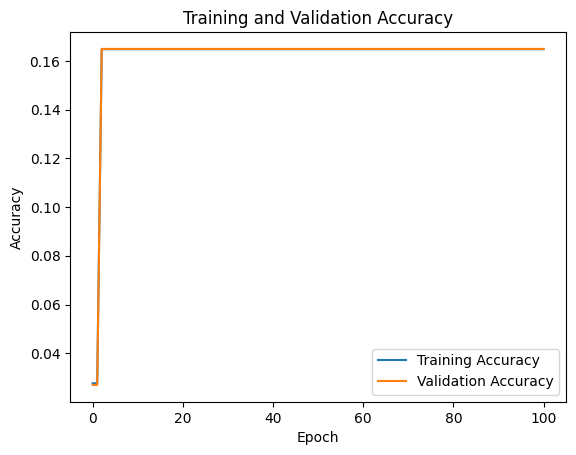

In [ ]:
#Zero
layer_dim=[512,128,64,num_labels]
activation=['sigmoid','sigmoid','sigmoid','sigmoid']
model=ANN_scratch(8,4,num_labels,layer_dim,activation,batch_size=16,learning_rate=0.001,weight_init='zero')
history=model.train(X_train.values.T,y_reshaped_train.T,X_val.values.T,y_reshaped_val.T,101,'cross_entropy',decay_rate=0.001,rst=0.1,decay_loop=75)
print(f"Accuracy on test data: {model.accuracy(X_test.values.T,y_reshaped_test.T,'cross_entropy')}")

#train and validation loss over epoch
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and alidation accuracy over epoch
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch:  1  Train Loss:  6.100199958924472e-09  Val loss:  7.412625217312053e-09
Epoch:  1  Train acc:  0.01382660687593423  Val acc:  0.013493253373313344
Epoch:  11  Train Loss:  2.1877963690335874e-07  Val loss:  2.650714212471213e-07
Epoch:  11  Train acc:  0.1647982062780269  Val acc:  0.16491754122938532
Epoch:  21  Train Loss:  8.144802488775786e-06  Val loss:  9.824959689769537e-06
Epoch:  21  Train acc:  0.1647982062780269  Val acc:  0.16491754122938532
Epoch:  31  Train Loss:  0.0003056045953286948  Val loss:  0.0003644710498692724
Epoch:  31  Train acc:  0.1647982062780269  Val acc:  0.16491754122938532
Epoch:  41  Train Loss:  0.006516905169123587  Val loss:  0.007235435568439054
Epoch:  41  Train acc:  0.1647982062780269  Val acc:  0.16491754122938532
Epoch:  51  Train Loss:  0.02828631265544018  Val loss:  0.029422416935738455
Epoch:  51  Train acc:  0.1647982062780269  Val acc:  0.16491754122938532
Epoch:  61  Train Loss:  0.04923795932728557  Val loss:  0.049897707270542

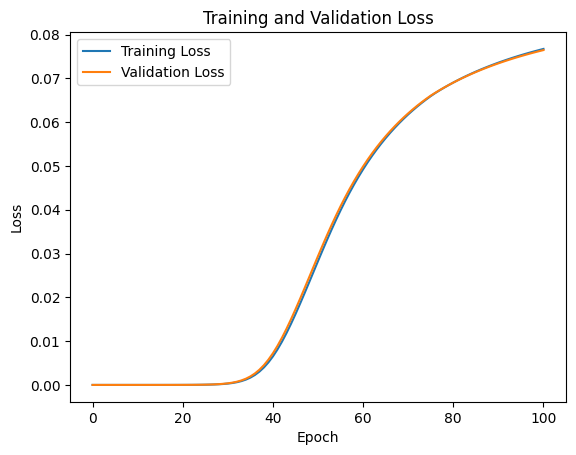

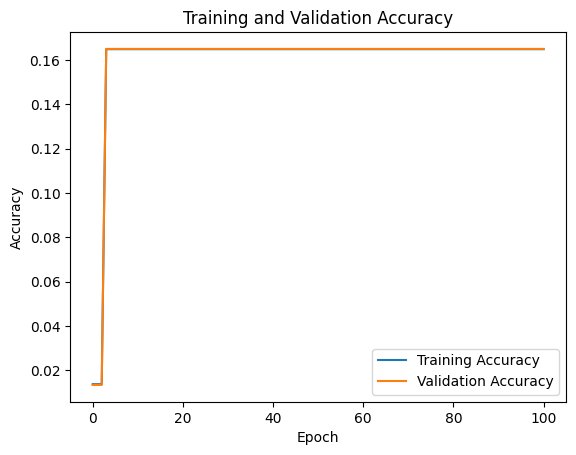

In [ ]:
#Constant
layer_dim=[512,64,64,num_labels]
activation=['sigmoid','sigmoid','sigmoid','sigmoid']
model=ANN_scratch(8,4,num_labels,layer_dim,activation,batch_size=512,learning_rate=0.001,weight_init='constant',onebynthweight_value=4,gradient_clip=1)
history=model.train(X_train.values.T,y_reshaped_train.T,X_val.values.T,y_reshaped_val.T,101,'cross_entropy',decay_rate=0.001,rst=0.1,decay_loop=75)
print(f"Accuracy on test data: {model.accuracy(X_test.values.T,y_reshaped_test.T,'cross_entropy')}")

#train and validation loss over epoch
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and alidation accuracy over epoch
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##Part E

Epoch:  1  Train Loss:  0.06255013981764661  Val loss:  0.0759364268449133
Epoch:  1  Train acc:  0.06726457399103139  Val acc:  0.05697151424287856
Epoch:  11  Train Loss:  0.10187269928969647  Val loss:  0.10073656766643324
Epoch:  11  Train acc:  0.14200298953662183  Val acc:  0.136431784107946
Epoch:  21  Train Loss:  0.09084465770609952  Val loss:  0.09060276146894553
Epoch:  21  Train acc:  0.17600896860986548  Val acc:  0.18290854572713644
Epoch:  31  Train Loss:  0.08714518202996323  Val loss:  0.08727641120350846
Epoch:  31  Train acc:  0.20964125560538116  Val acc:  0.21139430284857572
Epoch:  41  Train Loss:  0.08496458627417355  Val loss:  0.08534157266784274
Epoch:  41  Train acc:  0.22234678624813153  Val acc:  0.21139430284857572
Epoch:  51  Train Loss:  0.08351618334663452  Val loss:  0.08412809763165319
Epoch:  51  Train acc:  0.2384155455904335  Val acc:  0.20839580209895053
Epoch:  61  Train Loss:  0.08245227302164058  Val loss:  0.08325714548648863
Epoch:  61  Train

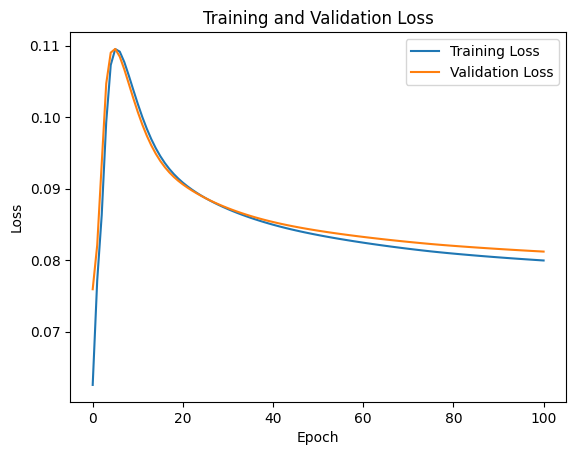

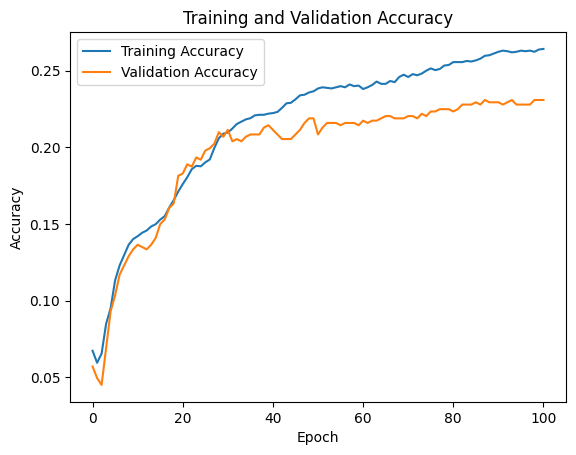

In [ ]:
#Random
layer_dim=[512,128,64,num_labels]
activation=['sigmoid','sigmoid','sigmoid','sigmoid']
model=ANN_scratch(8,4,num_labels,layer_dim,activation,batch_size=16,learning_rate=0.001,weight_init='random')
history=model.train(X_train.values.T,y_reshaped_train.T,X_val.values.T,y_reshaped_val.T,101,'cross_entropy',decay_rate=0.001,rst=0.1,decay_loop=75)
print(f"Accuracy on test data: {model.accuracy(X_test.values.T,y_reshaped_test.T,'cross_entropy')}")

#train and validation loss over epoch
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and alidation accuracy over epoch
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch:  1  Train Loss:  0.023164527936072876  Val loss:  0.025405723138290207
Epoch:  1  Train acc:  0.12219730941704036  Val acc:  0.12593703148425786
Epoch:  11  Train Loss:  0.07616731012064867  Val loss:  0.07597636027990726
Epoch:  11  Train acc:  0.11472346786248132  Val acc:  0.12143928035982009
Epoch:  21  Train Loss:  0.08432543871450635  Val loss:  0.08318117699070328
Epoch:  21  Train acc:  0.15695067264573992  Val acc:  0.1619190404797601
Epoch:  31  Train Loss:  0.08600773834797525  Val loss:  0.08465913043396586
Epoch:  31  Train acc:  0.1655455904334828  Val acc:  0.16041979010494753
Epoch:  41  Train Loss:  0.08641335589697437  Val loss:  0.08502397173228204
Epoch:  41  Train acc:  0.17040358744394618  Val acc:  0.1664167916041979
Epoch:  51  Train Loss:  0.08640447444404813  Val loss:  0.08501826887443188
Epoch:  51  Train acc:  0.1789985052316891  Val acc:  0.16491754122938532
Epoch:  61  Train Loss:  0.08622527411551396  Val loss:  0.08484518802317413
Epoch:  61  Tra

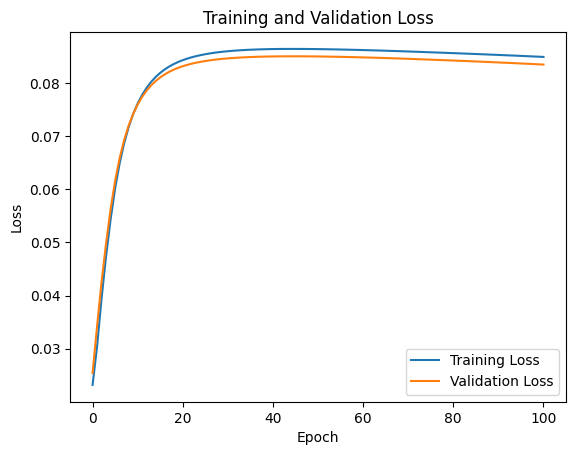

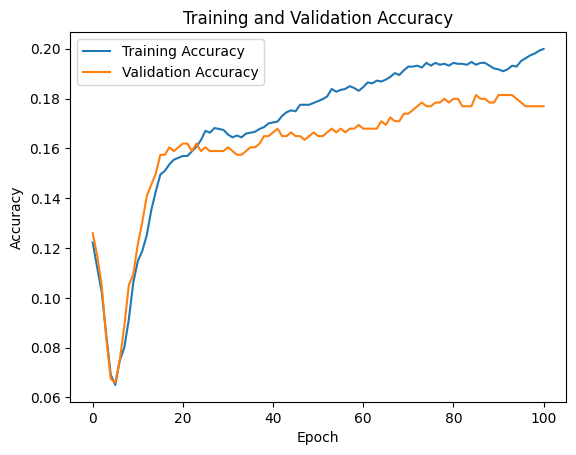

In [ ]:
#Random
layer_dim=[128,64,32,num_labels]
activation=['sigmoid','sigmoid','sigmoid','sigmoid']
model=ANN_scratch(8,4,num_labels,layer_dim,activation,batch_size=16,learning_rate=0.001,weight_init='random')
history=model.train(X_train.values.T,y_reshaped_train.T,X_val.values.T,y_reshaped_val.T,101,'cross_entropy',decay_rate=0.001,rst=0.1,decay_loop=75)
print(f"Accuracy on test data: {model.accuracy(X_test.values.T,y_reshaped_test.T,'cross_entropy')}")

#train and validation loss over epoch
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and alidation accuracy over epoch
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch:  1  Train Loss:  0.04470755489417274  Val loss:  0.04558392225047061
Epoch:  1  Train acc:  0.005605381165919282  Val acc:  0.008995502248875561
Epoch:  11  Train Loss:  0.06398414957344946  Val loss:  0.06514297289583548
Epoch:  11  Train acc:  0.12144992526158445  Val acc:  0.12143928035982009
Epoch:  21  Train Loss:  0.078053818535517  Val loss:  0.07844794095877639
Epoch:  21  Train acc:  0.16517189835575485  Val acc:  0.1634182908545727
Epoch:  31  Train Loss:  0.08371765095357109  Val loss:  0.08370636427749623
Epoch:  31  Train acc:  0.15881913303437967  Val acc:  0.1634182908545727
Epoch:  41  Train Loss:  0.08602231931045097  Val loss:  0.08580565402146069
Epoch:  41  Train acc:  0.16068759342301944  Val acc:  0.15742128935532235
Epoch:  51  Train Loss:  0.08707423515407148  Val loss:  0.08673485442413534
Epoch:  51  Train acc:  0.15807174887892378  Val acc:  0.1619190404797601
Epoch:  61  Train Loss:  0.08762502397847233  Val loss:  0.08720049620093058
Epoch:  61  Trai

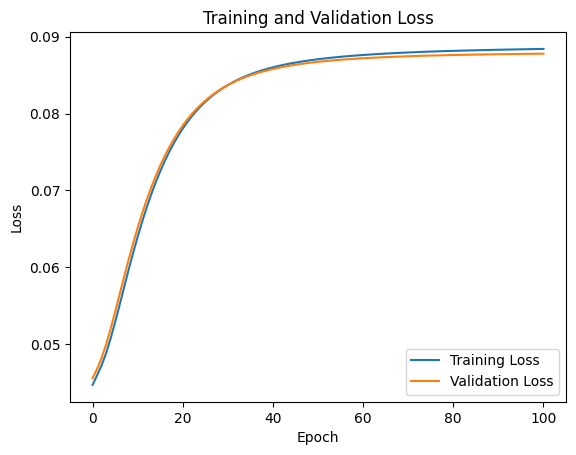

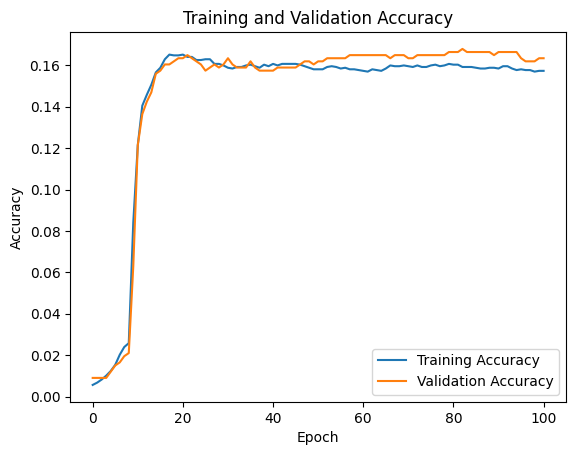

In [25]:
#Random
layer_dim=[32,16,8,num_labels]
activation=['sigmoid','sigmoid','sigmoid','sigmoid']
model=ANN_scratch(8,4,num_labels,layer_dim,activation,batch_size=16,learning_rate=0.001,weight_init='random')
history=model.train(X_train.values.T,y_reshaped_train.T,X_val.values.T,y_reshaped_val.T,101,'cross_entropy',decay_rate=0.001,rst=0.1,decay_loop=75)
print(f"Accuracy on test data: {model.accuracy(X_test.values.T,y_reshaped_test.T,'cross_entropy')}")

#train and validation loss over epoch
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and alidation accuracy over epoch
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Checking params load and save function

In [26]:
print(f"Accuracy on test data: {model.accuracy(X_test.values.T,y_reshaped_test.T,'cross_entropy')}")
model.save_weights('param_save')

Accuracy on test data: 0.15587529976019185


In [27]:
model=ANN_scratch(8,4,num_labels,layer_dim,activation,batch_size=64,learning_rate=0.001,weight_init='random')
print(f"Accuracy on test data: {model.accuracy(X_test.values.T,y_reshaped_test.T,'cross_entropy')}")

Accuracy on test data: 0.005995203836930456


In [28]:
model.load_weights('param_save')
print(f"Accuracy on test data: {model.accuracy(X_test.values.T,y_reshaped_test.T,'cross_entropy')}")

Accuracy on test data: 0.15587529976019185


We can see that our weights loaded successfully